In [50]:
%config IPCompleter.greedy=True

In [51]:
import csv
import pandas as pd
import dateutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import datetime
from scipy.integrate import simps
from numpy import trapz
from scipy.optimize import curve_fit
from mlp_wrapper import mlp_wrapper

## Reading the crowdfuning project data

In [162]:
pdf = pd.DataFrame.from_csv('crowdfunding.data.10.17.csv')
pdf = pdf.drop_duplicates('Project Id').reset_index()

C:\Users\Salman Ahmed\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Getting successful / failed projects

In [163]:
#pdf = pdf[pdf['Goal'] <= pdf['Pledged']] # for successful projects
pdf = pdf[pdf['Goal'] > pdf['Pledged']] # for failed projects
sids = pdf['Project Id'].tolist()

## Reading twitter data

In [199]:
tdf = pd.DataFrame.from_csv('twitter_data_new.csv')
tdf = tdf.reset_index()

C:\Users\Salman Ahmed\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [166]:
df = tdf[tdf['project id'].isin(sids)].reset_index()

## Convert date field to data object and filter out invalid date objects

In [195]:
'''Convert date string to date object'''
df['date']= pd.to_datetime(df['date'], errors='coerce')

'''cleaning the unknown format string dates'''
idx = df[df['date'].isnull()].index
df = df.drop(df.index[idx])

'''Sorting the data based on date'''
df = df.sort_values('date')

## Group the social data by project ids

In [170]:
groups = df.groupby('project id')

In [171]:
pids = df['project id'].unique()

In [173]:
def infection_function(x, Io, beta, N):
    return N * ((Io * np.exp(beta * N * x)) / (N + Io *(np.exp(beta * N  * x) - 1)))

In [174]:
def simple_epidemic(x, Io, beta):
    return 1 / (1 + ((1-Io)/Io) * np.exp(-beta * x))

In [209]:
'''For actual infection curve'''

BetaValues = dict()

for gid in range(1300, 1350):#len(pids)):
    
    group = groups.get_group(pids[gid])
    
    total_population = np.rint(group['username'].nunique() * 2).astype(int)
    #print(total_population)
    
    if total_population < 10 or total_population > 300:
        continue

    day_group = group.groupby([pd.Grouper(key='date', freq='D')])
    
    if len(day_group) < 7:# or len(day_group) > 8:
        continue

        
    Actual_Infection = dict()
    Actual_Freq = dict()

    Actual_Infection[0] = 0
    Actual_Freq[0] = 1
    
    infected_set = set()
    i = 1
    for g, gdf in day_group:
        
        if i > 10:
            break
        
        users_tweeted = set(gdf['username'])
        newly_infected = users_tweeted - infected_set
        
        Actual_Infection[i] = Actual_Infection.get(i-1, 0) + len(newly_infected)
        Actual_Freq[i] = Actual_Freq.get(i, 0) + 1
        
        infected_set.update(newly_infected)
        
        i += 1
        
    K = []
    P_k = []
    for key, value in sorted(Actual_Infection.items()):
        K.append(key)
        P_k.append(value)
        #print(Freq[key])    
    
    tp = total_population
    io = Actual_Infection.get(1)
    
    #def infection_function2(x, beta):
    #    return tp * ((io * np.exp(beta * tp * x)) / (tp + io *(np.exp(beta * tp  * x) - 1)))
    
    inital_guess = [io, 0.001, tp]
    #try:
    popt, pcov = curve_fit(infection_function, K, P_k, p0=inital_guess)
    #print(popt[0])
    BetaValues[pids[gid]] = popt[0]
    """print(total_population, popt)
    ydata = []
    for v in K:
        ydata.append(infection_function(v, popt[0], popt[1], popt[2]))

    plt.plot(K, P_k, '--r+')
    plt.plot(K, ydata, '--g^')
    plt.xlabel('Time')
    plt.ylabel('Infection')
    #plt.plot(tmpK, tmpPk, 'g')
    #plt.axis([0, 6, 0, 20])
    plt.savefig('simple_curve_fit'+str(pids[gid])+'.png', bbox_inches='tight', dpi=100)
    plt.show()"
    #except:
     #   continue

## Calcuate the average beta value

In [211]:
total = 0
beta = 0
for key, value in BetaValues.items():
    if value < 0 or value > 1:
        #print(key)
        continue
    beta += value
    total += 1
beta = beta / total

In [177]:
# calcuate the actual infection from the twitter data
def actual_infection(day_group):
    
    Actual_Infection = dict()
    Actual_Freq = dict()

    Actual_Infection[0] = 0
    Actual_Freq[0] = 1
    
    infected_set = set()
    i = 1
    for g, gdf in day_group:
        
        if i > 10:
            break
        
        users_tweeted = set(gdf['username'])
        newly_infected = users_tweeted - infected_set
        
        Actual_Infection[i] = Actual_Infection.get(i-1, 0) + len(newly_infected)
        Actual_Freq[i] = Actual_Freq.get(i, 0) + 1
        
        infected_set.update(newly_infected)
        
        i += 1
        
    K = []
    P_k = []
    for key, value in sorted(Actual_Infection.items()):
        K.append(key)
        P_k.append(value)
        #print(Freq[key])    
    
    return K, P_k

In [178]:
# predict the infection using CC model
def si_prediction(day_group, n, total_population, b):
    
    result = [gg[1] for gg in list(day_group)[:1]]
    
    initial_infection = result[0]['username'].nunique()

    initial_susceptible = total_population

    I = []
    S = []   
    
    I.append(initial_infection)
    S.append(initial_susceptible)   
    
    for t in range(1, n):
        if S[t-1] == 0:
            
            I.append(I[t-1])
            S.append(S[t-1]) 
            continue
        
        #infection_prob = b #infection_probability(I[t-1], delta, lamda, c)
        #infection_rate = np.rint(infection_prob * S[t-1] * I[t-1]).astype(int)
        
        infection_rate = infection_function(t, I[0], b, total_population)
        
        if infection_rate >= S[t-1]:
            new_infection = I[t-1] + S[t-1]
            susceptible_remain = 0
        else:
            new_infection = I[t-1] + infection_rate
            susceptible_remain = S[t-1]-infection_rate
        
        #print(I[t-1], infection_prob, infection_rate, new_infection, susceptible_remain)
        
        I.append(new_infection)
        S.append(susceptible_remain)
    
    return np.arange(n), I

In [71]:
image_count = 0

## Comparison of the actual and predicted (using SI model) infection

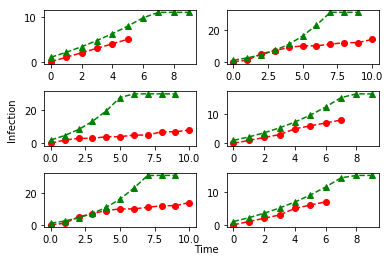

In [185]:
'''For actual infection curve'''

Actual_t = []
Prediction_t = []
Actual_It = []
Prediction_It = []

count = 0

while count < 6:
    
    taken_id = np.random.choice(pids, size = 1, replace=False)
    
    group = groups.get_group(taken_id[0])
    
    total_population = np.rint(group['username'].nunique() * 2).astype(int)
    #print(total_population)
    
    if total_population < 10 or total_population > 300:
        continue

    day_group = group.groupby([pd.Grouper(key='date', freq='D')])
    
    if len(day_group) < 3:# or len(day_group) > 8:
        continue

        
    t1, I_t1 = actual_infection(day_group)
    t2, I_t2 = si_prediction(day_group, 10, total_population, beta)

    Actual_t.append(t1)
    Actual_It.append(I_t1)
    Prediction_t.append(t2)
    Prediction_It.append(I_t2)
    
    count += 1
    
    #actual, = plt.plot(K, P_k, 'r')
    #prediction, = plt.plot(T, I_t, 'g')
    #plt.legend([actual, prediction], ['Actual', 'Prediction'])
    #plt.plot(tmpK, tmpPk, 'g')
    #plt.axis([0, 6, 0, 20])
    #plt.show()

f, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2)
ax0.plot(Actual_t[0], Actual_It[0], '--ro')
ax0.plot(Prediction_t[0], Prediction_It[0], '--g^')

ax1.plot(Actual_t[1], Actual_It[1], '--ro')
ax1.plot(Prediction_t[1], Prediction_It[1], '--g^')

ax2.plot(Actual_t[2], Actual_It[2], '--ro')
ax2.plot(Prediction_t[2], Prediction_It[2], '--g^')

ax3.plot(Actual_t[3], Actual_It[3], '--ro')
ax3.plot(Prediction_t[3], Prediction_It[3], '--g^')

ax4.plot(Actual_t[4], Actual_It[4], '--ro')
ax4.plot(Prediction_t[4], Prediction_It[4], '--g^')

ax5.plot(Actual_t[5], Actual_It[5], '--ro')
ax5.plot(Prediction_t[5], Prediction_It[5], '--g^')

f.subplots_adjust(hspace=0.5)
#plt.suptitle('Main title')
#plt.suptitle('')
f.text(0.5, 0.04, 'Time', ha='center')
f.text(0.04, 0.5, 'Infection', va='center', rotation='vertical')
#plt.savefig('si_actual_vs_prediction_success_diff'+str(image_count)+'.png', bbox_inches='tight', dpi=100)
plt.savefig('si_actual_vs_prediction_success_it'+str(image_count)+'.png', bbox_inches='tight', dpi=100)
plt.show()
image_count += 1